In [47]:
import pandas as pd
import duckdb as db
import os

pd.set_option('display.max_columns', None)

Connected to database: ../database/clinisys_all.duckdb
Database file exists: True

=== Available Schemas ===
          schema_name
0              bronze
1                gold
2                main
3              silver
4  information_schema
5                main
6          pg_catalog
7                main

=== Tables in Silver Schema (16 tables) ===
                           table_name  table_type
0         view_congelamentos_embrioes  BASE TABLE
1           view_congelamentos_ovulos  BASE TABLE
2      view_descongelamentos_embrioes  BASE TABLE
3        view_descongelamentos_ovulos  BASE TABLE
4            view_embrioes_congelados  BASE TABLE
5   view_extrato_atendimentos_central  BASE TABLE
6                   view_medicamentos  BASE TABLE
7       view_medicamentos_prescricoes  BASE TABLE
8                        view_medicos  BASE TABLE
9               view_micromanipulacao  BASE TABLE
10      view_micromanipulacao_oocitos  BASE TABLE
11                    view_orcamentos  BASE TABL
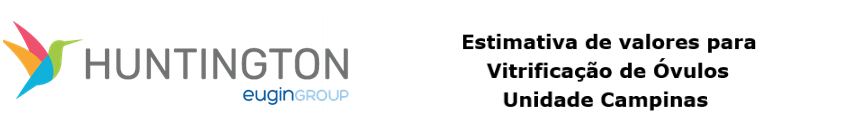
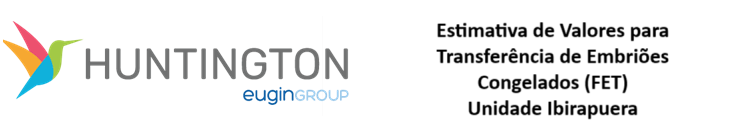
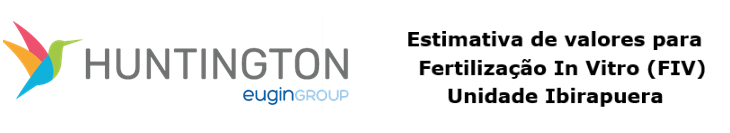
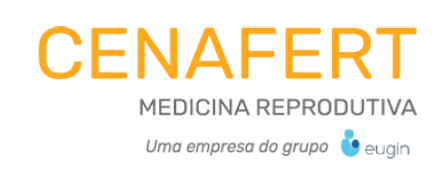

In [ ]:
# Connect to the clinisys_all database
path_to_db = '../../database/clinisys_all.duckdb'
conn = db.connect(path_to_db)

print(f"Connected to database: {path_to_db}")
print(f"Database file exists: {os.path.exists(path_to_db)}")

# List all schemas
schemas = conn.execute("SELECT schema_name FROM information_schema.schemata").fetchdf()
print("\n=== Available Schemas ===")
print(schemas)

# List all tables in silver schema
silver_tables = conn.execute("""
    SELECT table_name, table_type 
    FROM information_schema.tables 
    WHERE table_schema = 'silver'
    ORDER BY table_name
""").fetchdf()

print(f"\n=== Tables in Silver Schema ({len(silver_tables)} tables) ===")
print(silver_tables)

# Explore each table in silver schema
print("\n" + "="*80)
print("EXPLORING SILVER SCHEMA TABLES")
print("="*80)

for idx, row in silver_tables.iterrows():
    table_name = row['table_name']
    table_type = row['table_type']
    
    print(f"\n{'='*60}")
    print(f"TABLE: {table_name} (Type: {table_type})")
    print(f"{'='*60}")
    
    try:
        # Get table schema
        schema_info = conn.execute(f"""
            SELECT column_name, data_type, is_nullable
            FROM information_schema.columns 
            WHERE table_schema = 'silver' AND table_name = '{table_name}'
            ORDER BY ordinal_position
        """).fetchdf()
        
        print(f"\nSchema ({len(schema_info)} columns):")
        # print(schema_info.to_string(index=False))
        
        # Get row count
        count_result = conn.execute(f"SELECT COUNT(*) as row_count FROM silver.{table_name}").fetchdf()
        row_count = count_result['row_count'].iloc[0]
        print(f"\nTotal rows: {row_count:,}")
        
        # Get sample data (first 10 rows)
        if row_count > 0:
            sample_data = conn.execute(f"SELECT * FROM silver.{table_name} LIMIT 10").fetchdf()
            print(f"\nSample data (first 10 rows):")
            print(sample_data.to_string(index=False))
            
            # Show data types and null counts
            print(f"\nData info:")
            print(f"Shape: {sample_data.shape}")
            print(f"Memory usage: {sample_data.memory_usage(deep=True).sum() / 1024:.2f} KB")
            
            # Show null counts for each column
            null_counts = sample_data.isnull().sum()
            if null_counts.sum() > 0:
                print(f"\nNull counts in sample:")
                for col, null_count in null_counts.items():
                    if null_count > 0:
                        print(f"  {col}: {null_count}")
        else:
            print("\nTable is empty - no sample data to show")
            
    except Exception as e:
        print(f"Error exploring table {table_name}: {str(e)}")
    
    print(f"\n{'-'*60}")

# Close connection
conn.close()
print(f"\n{'='*80}")
print("EXPLORATION COMPLETE")
print(f"{'='*80}")

In [53]:
def extract_prontuario_data(target_prontuario=876950):
    """
    Extract all data for a specific prontuario from the four finops tables:
    - view_procedimentos_financas
    - view_orcamentos  
    - view_extrato_atendimento_central
    - view_tratamentos
    
    Args:
        target_prontuario (int): The prontuario number to extract data for
        
    Returns:
        tuple: Four DataFrames containing the extracted data
    """
    
    # Connect to the clinisys_all database
    path_to_db = '../database/clinisys_all.duckdb'
    conn = db.connect(path_to_db)
    
    print(f"Connected to database: {path_to_db}")
    print(f"Database file exists: {os.path.exists(path_to_db)}")
    
    print(f"\n{'='*80}")
    print(f"EXTRACTING DATA FOR PRONTUARIO: {target_prontuario}")
    print(f"{'='*80}")
    
    # First, let's check what columns are available in each table
    print("\nChecking table schemas...")
    
    # # Check procedimento_financas schema
    # try:
    #     schema_pf = conn.execute("""
    #         SELECT column_name, data_type 
    #         FROM information_schema.columns 
    #         WHERE table_schema = 'silver' AND table_name = 'view_procedimentos_financas'
    #         ORDER BY ordinal_position
    #     """).fetchdf()
    #     print(f"\nview_procedimentos_financas columns: {list(schema_pf['column_name'])}")
    # except Exception as e:
    #     print(f"Error checking procedimento_financas schema: {str(e)}")
    
    # Check orcamentos schema
    try:
        schema_orc = conn.execute("""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_schema = 'silver' AND table_name = 'view_orcamentos'
            ORDER BY ordinal_position
        """).fetchdf()
        print(f"\nview_orcamentos columns: {list(schema_orc['column_name'])}")
    except Exception as e:
        print(f"Error checking orcamentos schema: {str(e)}")
    
    # Check extrato_atendimento_central schema
    try:
        schema_eac = conn.execute("""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_schema = 'silver' AND table_name = 'view_extrato_atendimentos_central'
            ORDER BY ordinal_position
        """).fetchdf()
        print(f"\nview_extrato_atendimento_central columns: {list(schema_eac['column_name'])}")
    except Exception as e:
        print(f"Error checking extrato_atendimento_central schema: {str(e)}")
    
    # Check tratamentos schema
    try:
        schema_trat = conn.execute("""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_schema = 'silver' AND table_name = 'view_tratamentos'
            ORDER BY ordinal_position
        """).fetchdf()
        print(f"\nview_tratamentos columns: {list(schema_trat['column_name'])}")
    except Exception as e:
        print(f"Error checking tratamentos schema: {str(e)}")
    
    # # 1. Extract procedimento_financas data
    # print(f"\n1. EXTRACTING view_procedimentos_financas DATA")
    # print("-" * 50)
    # try:
    #     procedimento_financas_df = conn.execute(f"""
    #         SELECT * FROM silver.view_procedimentos_financas 
    #         WHERE prontuario = {target_prontuario}
    #     """).fetchdf()
        
    #     print(f"Found {len(procedimento_financas_df)} records in view_procedimentos_financas")
    #     if len(procedimento_financas_df) > 0:
    #         print("Sample data:")
    #         print(procedimento_financas_df.head())
    #         print(f"\nColumns: {list(procedimento_financas_df.columns)}")
    #     else:
    #         print("No data found for this prontuario")
            
    # except Exception as e:
    #     print(f"Error extracting procedimento_financas data: {str(e)}")
    #     procedimento_financas_df = pd.DataFrame()
    
    # 2. Extract orcamentos data
    print(f"\n2. EXTRACTING VIEW_ORCAMENTOS DATA")
    print("-" * 50)
    try:
        orcamentos_df = conn.execute(f"""
            SELECT * FROM silver.view_orcamentos 
            WHERE prontuario = {target_prontuario}
            ORDER BY id DESC
        """).fetchdf()
        
        print(f"Found {len(orcamentos_df)} records in view_orcamentos")
        if len(orcamentos_df) > 0:
            print("Sample data:")
            print(orcamentos_df.head())
            print(f"\nColumns: {list(orcamentos_df.columns)}")
        else:
            print("No data found for this prontuario")
            
    except Exception as e:
        print(f"Error extracting orcamentos data: {str(e)}")
        orcamentos_df = pd.DataFrame()
    
    # 3. Extract extrato_atendimento_central data
    print(f"\n3. EXTRACTING VIEW_EXTRATO_ATENDIMENTO_CENTRAL DATA")
    print("-" * 50)
    try:
        extrato_atendimento_central_df = conn.execute(f"""
            SELECT * FROM silver.view_extrato_atendimentos_central 
            WHERE prontuario = {target_prontuario}
            ORDER BY data DESC, inicio DESC
        """).fetchdf()
        
        print(f"Found {len(extrato_atendimento_central_df)} records in view_extrato_atendimento_central")
        if len(extrato_atendimento_central_df) > 0:
            print("Sample data:")
            print(extrato_atendimento_central_df.head())
            print(f"\nColumns: {list(extrato_atendimento_central_df.columns)}")
        else:
            print("No data found for this prontuario")
            
    except Exception as e:
        print(f"Error extracting extrato_atendimento_central data: {str(e)}")
        extrato_atendimento_central_df = pd.DataFrame()
    
    # 4. Extract tratamentos data
    print(f"\n4. EXTRACTING VIEW_TRATAMENTOS DATA")
    print("-" * 50)
    try:
        tratamentos_df = conn.execute(f"""
            SELECT * FROM silver.view_tratamentos 
            WHERE prontuario = {target_prontuario}
            ORDER BY id DESC
        """).fetchdf()
        
        print(f"Found {len(tratamentos_df)} records in view_tratamentos")
        if len(tratamentos_df) > 0:
            print("Sample data:")
            print(tratamentos_df.head())
            print(f"\nColumns: {list(tratamentos_df.columns)}")
        else:
            print("No data found for this prontuario")
            
    except Exception as e:
        print(f"Error extracting tratamentos data: {str(e)}")
        tratamentos_df = pd.DataFrame()
    
    # Summary
    print(f"\n{'='*80}")
    print(f"SUMMARY FOR PRONTUARIO {target_prontuario}")
    print(f"{'='*80}")
    print(f"view_procedimentos_financas: {len(procedimento_financas_df)} records")
    print(f"view_orcamentos: {len(orcamentos_df)} records")
    print(f"view_extrato_atendimento_central: {len(extrato_atendimento_central_df)} records")
    print(f"view_tratamentos: {len(tratamentos_df)} records")
    
    # Close connection
    conn.close()
    
    print(f"\n{'='*80}")
    print("DATA EXTRACTION COMPLETE")
    print(f"{'='*80}")
    print("DataFrames available:")
    print("- procedimento_financas_df")
    print("- orcamentos_df") 
    print("- extrato_atendimento_central_df")
    print("- tratamentos_df")
    
    return procedimento_financas_df, orcamentos_df, extrato_atendimento_central_df, tratamentos_df

if __name__ == "__main__":
    # Example usage
    procedimento_financas_df, orcamentos_df, extrato_atendimento_central_df, tratamentos_df = extract_prontuario_data(876950)
    
    # You can now work with the DataFrames
    print("\nDataFrames loaded successfully!")
    print(f"procedimento_financas_df shape: {procedimento_financas_df.shape}")
    print(f"orcamentos_df shape: {orcamentos_df.shape}")
    print(f"extrato_atendimento_central_df shape: {extrato_atendimento_central_df.shape}")
    print(f"tratamentos_df shape: {tratamentos_df.shape}") 

Connected to database: ../database/clinisys_all.duckdb
Database file exists: True

EXTRACTING DATA FOR PRONTUARIO: 876950

Checking table schemas...

view_orcamentos columns: ['id', 'prontuario', 'paciente', 'clinica', 'tipo_cotacao', 'profissional', 'status', 'status_entrega', 'nome_contato', 'telefone_contato', 'email_contato', 'comentario_para_paciente', 'comentario_do_paciente', 'orcamento_texto', 'descricao', 'fornecedor', 'qtd_cotada', 'unidade', 'valor_unidade', 'total', 'data_entrega', 'centro_custos', 'valor_total', 'forma', 'parcelas', 'comentarios', 'forma_parcela', 'valor', 'data_pagamento', 'descricao_pagamento', 'data', 'responsavel', 'data_entrega_orcamento', 'data_ultima_modificacao', 'hash', 'extraction_timestamp']

view_extrato_atendimento_central columns: ['agendamento_id', 'data', 'inicio', 'data_agendamento_original', 'medico', 'medico2', 'prontuario', 'evento', 'evento2', 'centro_custos', 'agenda', 'chegou', 'confirmado', 'paciente_codigo', 'paciente_nome', 'medic

In [54]:
orcamentos_df

,id,prontuario,paciente,clinica,tipo_cotacao,profissional,status,status_entrega,nome_contato,telefone_contato,email_contato,comentario_para_paciente,comentario_do_paciente,orcamento_texto,descricao,fornecedor,qtd_cotada,unidade,valor_unidade,total,data_entrega,centro_custos,valor_total,forma,parcelas,comentarios,forma_parcela,valor,data_pagamento,descricao_pagamento,data,responsavel,data_entrega_orcamento,data_ultima_modificacao,hash,extraction_timestamp
0,50189,876950,esposa,0000000015,None,31,E-mail,Realizado,None,None,None,<p>24/06/2025 - A pedido da Dra. Thais envio O...,None,<p><img alt=&quot;&quot; src=&quot;data:image/...,0000075997|@||@|,|@||@|,|@||@|,<NA>,"30.574,00|@|2.651,00|@|","24.932,00|@|2.651,00|@|",NaT,1,"24.932,00",Dinheiro,None,None,None,NaN,NaT,None,2025-06-24,4145,2025-06-24,2025-07-30,02981d5c81da53ab0cb7fdd757d90b53,2025-07-30 20:24:46


In [55]:
tratamentos_df 

,id,prontuario,unidade,idade_esposa,idade_marido,paciente_tratamento,tentativa,data_procedimento,hora_procedimento,tipo_procedimento,motivo_congelamento,tipo_inducao,protocolo,tipo_ciclo_congelado,tipo_preparo_endometrial,num_congelados,num_transferir,origem_ovulo,status_ovulo,prontuario_doadora,origem_espermatozoide,fonte_espermatozoide,status_espermatozoide,origem_material,material_heterologo,utero_substituicao,prontuario_genitores,prontuario_uter_substituicao,doacao_ovulos,destino_doacao_ovulos,prontuario_receptora,complemento_receptora,doacao_embrioes,era,emma,alice,matrice_lab,imunohistoquimica,outros_biopsia,consentimento,financeiro,embryoscope,pgt,era_auxiliar,recomendacao_transferencia,resultado_era,emma_resultado,alice_resultado,picsi,hatching_od,hatching_oe,medicacao_parental,peso_paciente,altura_paciente,fumante_paciente,data_dum,peso_conjuge,altura_conjuge,fumante_conjuge,fator_infertilidade1,fator_infertilidade2,fator_infertilidade3,fsh_exame,foliculos_antrais,data_histeroscopia,data_inicio_inducao,dias_inducao_preparo,paciente_inducao,ropa,data_inicio_agonista,gnrh,fsh_agonista,lh_agonista,outros_medicamentos,gonal,menogon,menopur,pergoveris,elonva,serofene_clomid_indux,luveris,puregon,letrozole,fostimon,merional,rekovelle,descricao_outras_medicacoes,dose_total_fsh,dose_total_lh,dose_total_fsh_lh,coorte_e2,coorte_aco,coorte_progesterona,coq10,hormonal_combinado,coorte_testosterona,agonista_coorte,coorte_antagonista,coorte_dhea,utilizado_hcg,motivo_cancelamento_hcg,data_hcg,horario_planejado_hcg,horario_real_hcg,ovidrel,gonapeptyl,dose_gonapeptyl,outras_complicacoes_hcg,dose_outras_complicacoes,lupron,outros_hcg,descricao_outros_hcg,data_inicio_progesterona,p4_inicio_progesterona,estradiol_fase_lutea,progesterona_fase_lutea,progesterona_oral,progesterona_vaginal,progesterona_injetavel,combinacao_oral_vaginal,nenhuma_progesterona,hcg_progesterona,data_congelamento,metodo_descongelamento,valor_palheta,manter_excedentes,observacoes_descongelamento,dia_transferencia,data_transferencia,medida_endometrio,padrao_endometrio,p4_transferencia,motivo_nao_transferir,motivo_cancelamento_tratamento,ligacao_enfermagem,beta_valor,beta_valor2,data_ultrassom1,data_ultrassom2,num_sacos_gestacionais,tsh,data_ultrassom1_contato,descricao_ultrassom1,bcf_embrião1_status,bcf_embrião1_fonte,data_ultrassom2_contato,descricao_ultrassom2,data_ultrassom3_contato,descricao_ultrassom3,resultado_tratamento,analise_genetica,resultado_analise_genetica,motivo_perda_aborto,data_nascimento_bebes,obstetra,nome_bebe1,sexo_bebe1,peso_bebe1,altura_bebe1,idade_gestacional_bebe1,via_parto_bebe1,viabilidade_bebe1,anomalias_bebe1,nome_bebe2,sexo_bebe2,peso_bebe2,altura_bebe2,idade_gestacional_bebe2,via_parto_bebe2,viabilidade_bebe2,anomalias_bebe2,nome_bebe3,sexo_bebe3,peso_bebe3,altura_bebe3,idade_gestacional_bebe3,via_parto_bebe3,viabilidade_bebe3,anomalias_bebe3,nome_bebe4,sexo_bebe4,peso_bebe4,altura_bebe4,idade_gestacional_bebe4,via_parto_bebe4,viabilidade_bebe4,anomalias_bebe4,observacoes_bebes,observacoes_gerais,usuario_responsavel,responsavel_informacoes,hash,extraction_timestamp
0,36091,876950,15,33,32,esposa,1,NaT,None,Ciclo a Fresco FIV,None,Convencional,Progesterona,None,Hormonal,None,None,Homólogo,Fresco,NaN,Homólogo,Sêmen,Fresco,None,None,Não,NaN,NaN,Não,None,NaN,None,Não,None,None,None,None,None,None,None,None,None,Não,None,None,None,None,None,Não,Não,Sim,None,57,"1,67",None,15/07/2025,None,None,None,Endometriose,Fator feminino anatômico,None,None,None,None,17/07/2025,None,esposa,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Não utilizado,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Congelamento de Óvulos,Não,None,None,None,None,None,None,N

In [56]:
extrato_atendimento_central_df

,agendamento_id,data,inicio,data_agendamento_original,medico,medico2,prontuario,evento,evento2,centro_custos,agenda,chegou,confirmado,paciente_codigo,paciente_nome,medico_nome,medico_sobrenome,medico2_nome,centro_custos_nome,agenda_nome,procedimento_nome,hash,extraction_timestamp
0,1455571,2025-08-04,1900-01-01 10:15:00,NaT,<NA>,<NA>,876950.0,71,None,1,31,None,0,876950,Ana Caroline Camargo,None,None,None,1. HTT SP - Ibirapuera,Tarefas FIV - IBIRAPUERA,None,a6a1ea145a342cd1e86d92a9e6d9d016,2025-07-29 19:04:07
1,1457052,2025-08-04,1900-01-01 10:15:00,NaT,<NA>,<NA>,876950.0,71,None,1,31,None,0,876950,Ana Caroline Camargo,None,None,None,1. HTT SP - Ibirapuera,Tarefas FIV - IBIRAPUERA,None,494d29b6a655ee01ced5dce8ae9421b4,2025-07-31 19:04:47
2,1457051,2025-08-03,1900-01-01 10:15:00,NaT,<NA>,<NA>,876950.0,71,None,1,31,None,0,876950,Ana Caroline Camargo,None,None,None,1. HTT SP - Ibirapuera,Tarefas FIV - IBIRAPUERA,None,b1d1d904d1019128e65cdaef8264935b,2025-07-31 19:04:47
3,1455570,2025-08-03,1900-01-01 10:15:00,NaT,<NA>,<NA>,876950.0,71,None,1,31,None,0,876950,Ana Caroline Camargo,None,None,None,1. HTT SP - Ibirapuera,Tarefas FIV - IBIRAPUERA,None,283848bd005692ca0f23f69089da6b13,2025-07-29 19:04:07
4,1455569,2025-07-31,1900-01-01 10:15:00,NaT,<NA>,<NA>,876950.0,71,None,1,31,None,0,876950,Ana Caroline Camargo,None,None,None,1. HTT SP - Ibirapuera,Tarefas FIV - IBIRAPUERA,None,be977e32f4337d6d0f07d5bc7eb0cd2b,2025-07-29 19:04:07
5,1457050,2025-07-31,1900-01-01 10:15:00,NaT,<NA>,<NA>,876950.0,71,None,1,31,None,0,876950,Ana Caroline Camargo,None,None,None,1. HTT SP - Ibirapuera,Tarefas FIV - IBIRAPUERA,None,11fc7b48c09b66f468e7183f367fa219,2025-07-31 19:04:47
6,1455568,2025-07-30,1900-01-01 10:15:00,NaT,<NA>,<NA>,876950.0,71,None,1,31,None,0,876950,Ana Caroline Camargo,None,None,None,1. HTT SP - Ibirapuera,Tarefas FIV - IBIRAPUERA,None,632c969a7897d6ba029561de9c91a2e8,2025-07-29 19:04:07
7,1457049,2025-07-29,1900-01-01 10:15:00,NaT,<NA>,<NA>,876950.0,71,None,1,31,None,0,876950,Ana Caroline Camargo,None,None,None,1. HTT SP - Ibirapuera,Tarefas FIV - IBIRAPUERA,None,57ff4d4563422448876f7c766a1bfc52,2025-07-31 19:04:47
8,1455567,2025-07-29,1900-01-01 10:15:00,NaT,<NA>,<NA>,876950.0,71,None,1,31,None,0,876950,Ana Caroline Camargo,None,None,None,1. HTT SP - Ibirapuera,Tarefas FIV - IBIRAPUERA,None,14ca2a33704ba05c40a68d790c0073e5,2025-07-29 19:04:07
9,1452499,2025-07-28,1900-01-01 10:20:00,NaT,<NA>,31,876950.0,765459,None,1,72,Atendido,1,876950,Ana Caroline Camargo,None,None,Thais Sanches Domingues,1. HTT SP - Ibirapuera,Sala de Procedimento 01 - IBIRAPUERA,Aspiração Folicular: FIV,c767d880fbbed249890ab2fb53577d14,2025-07-28 19:04:08


,prontuario,prontuario_esposa,prontuario_marido,prontuario_responsavel1,prontuario_responsavel2,prontuario_esposa_pel,prontuario_marido_pel,prontuario_esposa_pc,prontuario_marido_pc,prontuario_responsavel1_pc,prontuario_responsavel2_pc,prontuario_esposa_fc,prontuario_marido_fc,prontuario_esposa_ba,prontuario_marido_ba
0,220187,220187,511300,220189,220190,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2
1,220187,220187,511300,220189,220190,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2
2,220187,220187,511300,220189,220190,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2
3,220187,220187,511300,220189,220190,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2
4,220187,220187,511300,220189,220190,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97531,886161,886161,886162,886163,886164,-2,-2,886161,886162,886163,886164,-2,-2,-2,-2
97532,886161,886161,886162,886163,886164,-2,-2,886161,886162,886163,886164,-2,-2,-2,-2
97533,886161,886161,886162,886163,886164,-2,-2,886161,886162,886163,886164,-2,-2,-2,-2
97534,781971,785097,785098,-2,-2,-2,-2,785097,785098,-2,-2,-2,-2,21971,-2


prontuario                    int64
prontuario_esposa             int64
prontuario_marido             int64
prontuario_responsavel1       int64
prontuario_responsavel2       int64
prontuario_esposa_pel         int64
prontuario_marido_pel         int64
prontuario_esposa_pc          int64
prontuario_marido_pc          int64
prontuario_responsavel1_pc    int64
prontuario_responsavel2_pc    int64
prontuario_esposa_fc          int64
prontuario_marido_fc          int64
prontuario_esposa_ba          int64
prontuario_marido_ba          int64
dtype: object

,Cliente
0,751633
1,751633
2,525965
3,805229
4,88042


Coluna: prontuario. Total de prontuarios: 4638
Matches found: 2627
Non-matches remaining: 2011 

Coluna: prontuario_esposa. Total de prontuarios: 2011
Matches found: 464
Non-matches remaining: 1548 

Coluna: prontuario_marido. Total de prontuarios: 1548
Matches found: 923
Non-matches remaining: 625 

Coluna: prontuario_responsavel1. Total de prontuarios: 625
Matches found: 63
Non-matches remaining: 562 

Coluna: prontuario_responsavel2. Total de prontuarios: 562
Matches found: 2
Non-matches remaining: 560 

Coluna: prontuario_esposa_pel. Total de prontuarios: 560
Matches found: 3
Non-matches remaining: 557 

Coluna: prontuario_marido_pel. Total de prontuarios: 557
Matches found: 3
Non-matches remaining: 554 

Coluna: prontuario_esposa_pc. Total de prontuarios: 554
Matches found: 191
Non-matches remaining: 364 

Coluna: prontuario_marido_pc. Total de prontuarios: 364
Matches found: 87
Non-matches remaining: 277 

Coluna: prontuario_responsavel1_pc. Total de prontuarios: 277
Matches foun

,Cliente,prontuario,matched_on
0,525965,525965.0,prontuario
1,805229,805229.0,prontuario
2,816280,816280.0,prontuario
3,796844,796844.0,prontuario
4,821908,821908.0,prontuario
...,...,...,...
4635,24941,24941.0,Cliente
4636,869243,869243.0,Cliente
4637,89501,89501.0,Cliente
4638,38974,38974.0,Cliente


,Cliente,prontuario,matched_on
4144,81176,681176.0,prontuario_esposa_pc
4145,81176,833421.0,prontuario_esposa_pc


,Matched On,Proportion,Cumulative Proportion
0,prontuario,0.566164,0.566164
1,prontuario_marido,0.198922,0.765086
2,prontuario_esposa,0.100000,0.865086
3,Cliente,0.059267,0.924353
4,prontuario_esposa_pc,0.041164,0.965517
5,prontuario_marido_pc,0.018750,0.984267
6,prontuario_responsavel1,0.013578,0.997845
7,prontuario_esposa_pel,0.000647,0.998491
8,prontuario_marido_pel,0.000647,0.999138
9,prontuario_responsavel2,0.000431,0.999569


Shape before: (30293, 15)
Shape after: (30294, 17)
